In [56]:
# load package
import pandas as pd
import numpy as np
import time

In [57]:
# load package
from plotly.offline import iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

### Sub：Metrics
---

In [58]:
# Metrics
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calcError(origin, forecast):
    print("RMSE", RMSE(origin, forecast))
    print("MAPE", MAPE(origin, forecast))

In [59]:
def showPlot(true, prediction, title, sub_title, size='M', save=False):
    # 列印績效圖表，可以選擇是否儲存
    size == 'L' and plt.figure(figsize=(28, 10))
    plt.plot(true, color='red', label='Real')
    plt.plot(prediction, color='blue', label='Prediction')
    plt.title('PeakLoad Prediction %s %s t:%d' % (title, sub_title, time))
    plt.xlabel('Time')
    plt.ylabel('kW')
    plt.legend()
    save and plt.savefig('Image/%s-%s-%d.png' % (title, sub_title, time))
    plt.show()

In [60]:
def showModelLoss(history, startFrom=10):
    plt.plot(history.history['loss'][startFrom:], label = 'loss')
    plt.plot(history.history['val_loss'][startFrom:], color = 'red', label = 'val_loss')
    plt.legend()
    plt.show()

### Sub：Data Processing
---

In [61]:
# 資料特徵擷取
def augFeatures(data, features_select):
    data = pd.DataFrame(data[features_select])
    return data

In [62]:
from sklearn.preprocessing import MinMaxScaler
# 資料正規化與尺度還原
def normalize(data, trainTo):
    # 獲得訓練資料的尾端
    num_train_to = df[df['Date'] == trainTo].index.item() + 1
    trainData = pd.DataFrame(data[:num_train_to])
    # 僅使用資訓練資料計算正歸化倍率
    sc = MinMaxScaler(feature_range=(0, 1))
    sc.fit_transform(trainData)
    data_scaled = pd.DataFrame(sc.transform(data))
    return sc, data_scaled
def deNormalize(sc, value):
    value_unscaled = value * \
        (sc.data_max_[0]-sc.data_min_[0]) + sc.data_min_[0]
    value_unscaled = value_unscaled.reshape(value_unscaled.shape[0])
    return value_unscaled

In [63]:
# 根據給定的時間範圍自動產生訓練集
def split_train(data, trainFrom, trainTo, pastDay=7, futureDay=7):
    num_train_from = df[df['Date'] == trainFrom].index.item()
    num_train_to = df[df['Date'] == trainTo].index.item() + 1
    RawTrain = data[num_train_from:num_train_to]
    # print('RawTrain', RawTrain.shape)
    return RawTrain
# 根據給定的時間範圍自動產生測試集
def split_test(data, testFrom, testTo, pastDay=7, futureDay=7):
    num_test_from = df[df['Date'] == testFrom].index.item()
    num_test_to = df[df['Date'] == testTo].index.item() + 1
    RawTest = data[num_test_from-pastDay:num_test_to]
    # print('RawTest', RawTest.shape)
    return RawTest
# 拆分訓練與驗證，需要手動切割時才使用
def split_val(X, Y, rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [64]:
# 滾動訓練資料
def buildTrain(train, pastDay, futureDay):
    X_train, Y_train = [], []
    for i in range(pastDay, len(train)-futureDay):
        X_train.append(train[i-pastDay:i])
        Y_train.append(train[i:i+futureDay, 0])  # kW
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    # print('X_train.shape, Y_train.shape', X_train.shape, Y_train.shape)
    return X_train, Y_train

In [65]:
# 滾動測試資料
def buildTest(test, pastDay, futureDay):
    input_set, truth_set = test, test[pastDay:]
    X_test, Y_truth = [], []
    for i in range(0, int((test.shape[0]-pastDay)/futureDay)):
        X_test.append(input_set[futureDay*i:futureDay*i+pastDay])
        Y_truth.append(truth_set[i*futureDay:(i+1)*futureDay, 0])  # kW
    testInput, testTruth = np.array(X_test), np.array(Y_truth)
    testInput = testInput.reshape(testInput.shape[0], testInput.shape[1], testInput.shape[2])
    testTruth = testTruth.reshape(testTruth.shape[0] * testTruth.shape[1])
    # print('testInput.shape, testTruth.shape', testInput.shape, testTruth.shape)
    return testInput, testTruth

### Sub：Model
---

In [66]:
# 分配顯存空間，未使用 tensorflow-GPU 可以跳過這段
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.45
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [67]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Flatten, RepeatVector, Activation
from keras.layers import SimpleRNN, LSTM, CuDNNLSTM
from keras.layers import Dropout, BatchNormalization, Bidirectional
from keras import optimizers, regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [68]:
def buildModel(shape, train_x, train_y):
    epochs, batch_size = 1000, 32
    model = Sequential()
    model.add(SimpleRNN(units=200, input_shape=(shape[1], shape[2])))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(RepeatVector(7))
    
    model.add(SimpleRNN(200, return_sequences=True))
#     model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(TimeDistributed(Dense(200, activation='relu')))
#     model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(units=futureDay))
    
    model.compile(loss='mse', optimizer='adam')
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=30, mode='min', verbose=0)
    earlyStop = EarlyStopping(
        monitor="val_loss", patience=150, mode="min", restore_best_weights=True)
    modelResult = model.fit(train_x, train_y,
                            epochs=epochs, batch_size=batch_size,
                            verbose=0,
                            validation_split=0.1,
                            callbacks=[reduce_lr, earlyStop])
    return model, modelResult

In [69]:
def model_forecast(model, input_data):
    forecast_temp = model.predict(input_data)
    forecast = forecast_temp.reshape(
        forecast_temp.shape[0] * forecast_temp.shape[1])
    return forecast

In [70]:
def model_evaluate(model, sc, truth, input_set):
    truth = pd.DataFrame(truth)
    truth = deNormalize(sc, truth.values)
    predict = model_forecast(model, input_set)
    predict = deNormalize(sc, predict)
    return predict

### Main
---

In [71]:
# 資料讀入
df = pd.read_csv('Data/IndustryElec_processed_20160101_20190930(true_peakload).csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.shape

(1461, 11)

In [72]:
features = [
    'PeakLoad(MW)',
    'isHoliday_shift7',
    'dayOfYear',
    'weekUpdate_shift7',
    'Temp_Taipei_shift7',
]

In [73]:
# 預測時間
trainFrom = '2017-01-02'
trainTo = '2018-12-30'
# 步數選擇
pastDay = 7
futureDay = 7

In [74]:
# 特徵選取
RawData = augFeatures(df, features)

# 正規化
sc, RawData = normalize(RawData, trainTo)

# 資料範圍選取
RawTrain = split_train(RawData, trainFrom, trainTo, pastDay, futureDay)

# 資料打包
X_train, Y_train = buildTrain(RawTrain.values, pastDay, futureDay)

round:  0


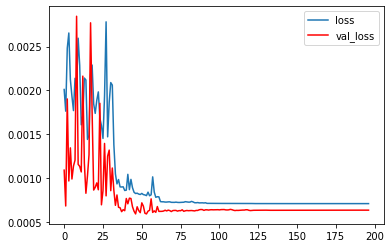

round:  1


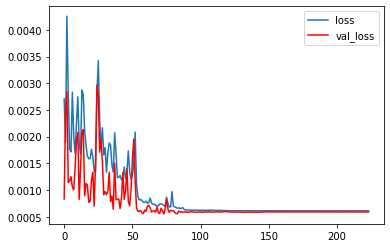

round:  2


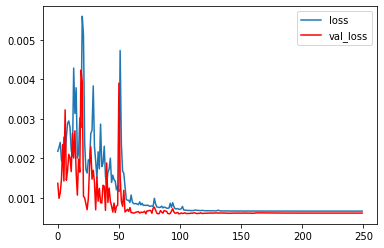

round:  3


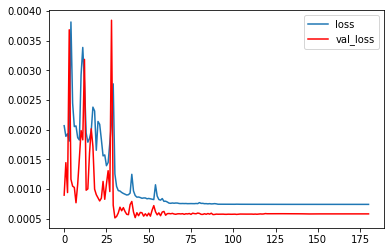

round:  4


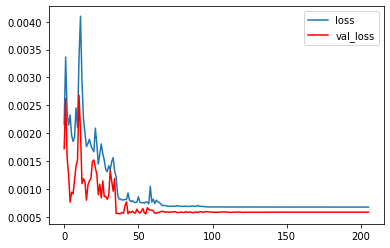

round:  5


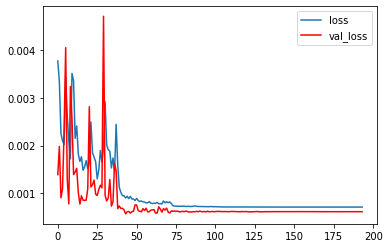

round:  6


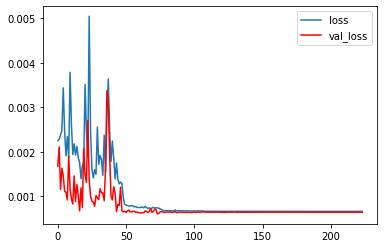

round:  7


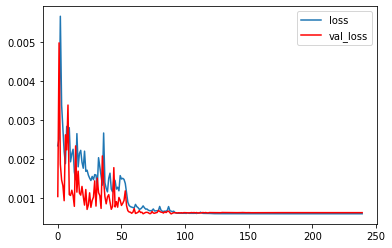

round:  8


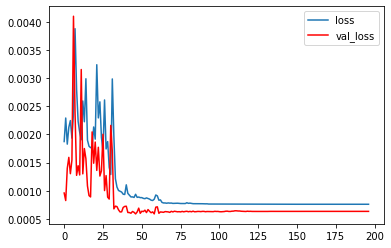

round:  9


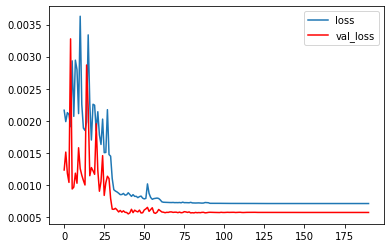

Wall time: 13min 4s


In [45]:
%%time
model_save = []

# 為求公平衡量模型，執行 n次
for i in range(10):
    print("round: ", str(i))
    model, modelResult = buildModel(X_train.shape, X_train, Y_train)
    showModelLoss(modelResult, startFrom=20)
    model_save.append(model)  # 儲存 model 供未來使用

In [55]:
# load model
from keras.models import load_model
model_save = []
for i in range(10):
    print("round: ", str(i))
    model = load_model('Model/PeakLoad/PeakLoad_%d_%d.h5'%(time, i))
    model_save.append(model) 

round:  0
round:  1
round:  2
round:  3
round:  4
round:  5
round:  6
round:  7
round:  8
round:  9


## Log Setting
##### ( 設定本次實驗的戳記代碼 )
---

In [75]:
time = 1
# save = True
save = False
# model_name = '(RNN_with_BN)'
model_name = '(RNN_PK)'

## Test Prediction
---

In [89]:
# 建構物件
dataFrom = '2016-01-01'
dataTo = '2019-10-07' # 2019-09-30(+7, shift)
num_data_from = df[df['Date'] == dataFrom].index.item()
num_data_to = df[df['Date'] == dataTo].index.item() + 1
d = {'date': pd.date_range(start = dataFrom, end = dataTo),
     'truth': df[num_data_from:num_data_to]['PeakLoad(MW)'],
     'pred': df[num_data_from:num_data_to]['PeakLoad(MW)']}
df_original = pd.DataFrame(d)
df_original.shape

(1376, 3)

In [78]:
# 定義日期切割
weekCut = ['MON/SUN', 'TUE/MON', 'WED/TUE',
           'THU/WED', 'FRI/WED', 'SAT/FRI', 'SUN/STA']
# +7(shift)
weekCut_from_to = [{'from': '2019-01-07',
                    'to': '2019-10-06'},
                   {'from': '2019-01-01',
                    'to': '2019-10-07'},
                   {'from': '2019-01-02',
                    'to': '2019-10-01'},
                   {'from': '2019-01-03',
                    'to': '2019-10-02'},
                   {'from': '2019-01-04',
                    'to': '2019-10-03'},
                   {'from': '2019-01-05',
                    'to': '2019-10-04'},
                   {'from': '2019-01-06',
                    'to': '2019-10-05'}]

## 尖峰負載替換
---

In [79]:
# 替換特殊日

for i in range(len(weekCut)):
    df_update = df_original
    print("%s" % (weekCut[i]))
    # 選取要重新預測的期間
    weekCut_range = (df_original['date'] >= weekCut_from_to[i].get('from')) & (
        df_original['date'] <= weekCut_from_to[i].get('to'))

    weekCutRaw = split_test(RawData,
                            weekCut_from_to[i].get('from'),
                            weekCut_from_to[i].get('to'),
                            pastDay, futureDay)
    weekCutInput, weekCutTruth = buildTest(weekCutRaw.values, pastDay, futureDay)
    # 特殊日的替換也要使用 10 個 model 預測後取平均
    weekCutPredict = []
    for j in range(10):
        temp = model_evaluate(model_save[j], sc, weekCutTruth, weekCutInput)
        weekCutPredict.append(temp.reshape(temp.shape[0]))
    weekCutPredict = np.array(weekCutPredict).mean(axis=0)

    df_update.at[df_update[weekCut_range].index.tolist(),'pred'] = weekCutPredict
    # 計算替換後的績效
    df_weekCut = df_update[weekCut_range]
    calcError(df_weekCut['truth'], df_weekCut['pred'])

MON/SUN


FailedPreconditionError: 2 root error(s) found.
  (0) Failed precondition: Error while reading resource variable dense_22_2/kernel from Container: localhost. This could mean that the variable was uninitialized. Not found: Container localhost does not exist. (Could not find resource: localhost/dense_22_2/kernel)
	 [[{{node dense_22_2/MatMul/ReadVariableOp}}]]
	 [[dense_22_2/BiasAdd/_19]]
  (1) Failed precondition: Error while reading resource variable dense_22_2/kernel from Container: localhost. This could mean that the variable was uninitialized. Not found: Container localhost does not exist. (Could not find resource: localhost/dense_22_2/kernel)
	 [[{{node dense_22_2/MatMul/ReadVariableOp}}]]
0 successful operations.
0 derived errors ignored.

In [90]:
df_update['pred'] = df_update['pred'].shift(-7, axis=0)

## Save Model
---

In [53]:
# import h5py

# for i in range(10):
#     print("round: ", str(i))
#     model_save[i].save('Model/PeakLoad/PeakLoad_%d_%d.h5'%(time, i))

round:  0
round:  1
round:  2
round:  3
round:  4
round:  5
round:  6
round:  7
round:  8
round:  9
